# Skeleton Threat Detection

In [1]:
import time
import numpy as np
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

# Part 1: Load Data

In [2]:
x = np.empty((1,9,2))
rele_dexes = [1,2,3,4,5,6,7,9,12]
right_elbow = 3
right_wrist = 4
folders = ["High_ordered/keypoints/", "Medium_ordered/keypoints/", "Low_ordered/keypoints/"]
threats = [0,1,2]
y = []
last_count = 0
for folder in range(len(folders)):
    for f in listdir(folders[folder]):
        skeletons = np.load(folders[folder]+f)
        if skeletons.size != 1:
            for skele in skeletons:
                if skele[rele_dexes].all() > .0001:
                    skele[:,0:2] -= skele[right_elbow,0:2]
                    forearm_len = np.sqrt(skele[right_wrist][0]**2+skele[right_wrist][1]**2)
                    skele[:,0:2] /= forearm_len
                    x = np.vstack((x,np.expand_dims(skele[rele_dexes,0:2],axis=0)))
    y = np.concatenate((y,[threats[folder]]*(x.shape[0]-last_count)))
    last_count = x.shape[0]
                    
x = x.reshape([x.shape[0],x.shape[1]*x.shape[2]])

        
print(x.shape)
print(y.shape)
print(x[-1])

[[6.90056183e-310 4.65021121e-310]
 [6.90056199e-310 6.90050599e-310]
 [6.90056199e-310 6.90055463e-310]
 [6.90056199e-310 4.65020820e-310]
 [6.90055469e-310 4.65020820e-310]
 [4.65020820e-310 6.90056203e-310]
 [6.90056015e-310 6.90055470e-310]
 [6.90056205e-310 6.90056096e-310]
 [6.90050600e-310 6.90056203e-310]]
(1549, 18)
(1549,)
[-1.14879715 -1.0680207  -0.50251734 -1.15777564  0.          0.
  0.43987265  0.8980602  -1.73252392 -0.94244558 -1.82236588  0.10790823
 -1.80436289  0.52977294 -0.84384251  0.57481354 -1.58882546  0.55679184]


In [3]:
train_x, test_x, train_y, test_y = train_test_split(x,y,test_size=.15)

oh_train_y = np.array(train_y,dtype=np.int64)
num_labels = len(np.unique(oh_train_y))
oh_train_y = np.eye(num_labels)[oh_train_y]

oh_test_y = np.array(test_y,dtype=np.int64)
num_labels = len(np.unique(oh_test_y))
oh_test_y = np.eye(num_labels)[oh_test_y]

print(train_x.shape)
print(test_x.shape)
print(len(oh_train_y))
print(len(oh_test_y))

# columns: x, y, confidence
# https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md

(1316, 18)
(233, 18)
1316
233


# Create and Train Model

In [4]:
from feedforward_model import *

In [5]:
model = feedforward(x.shape[1],len(threats),hidden_layer_size=[8],learning_rate=.0025,train_keep_prob=[.5])

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [6]:
model.train(train_x,oh_train_y,test_x,oh_test_y,epochs=30,batch_size=64)

number of batches for training: 20
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.497854077253216%
epoch 3
Best validation accuracy! iteration:50 accuracy: 56.22317596566524%
epoch 4
Best validation accuracy! iteration:75 accuracy: 63.94849785407726%
epoch 5
Best validation accuracy! iteration:100 accuracy: 66.09442060085837%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 66.52360515021459%
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 66.95278969957081%
epoch 14
Best validation accuracy! iteration:275 accuracy: 67.81115879828327%
epoch 15
Best validation accuracy! iteration:300 accuracy: 68.24034334763948%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 69.09871244635193%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 69.52789699570815%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 70.3862660944206%
ep

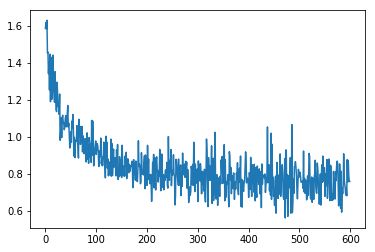

In [7]:
model.plot()

In [8]:
labels = np.array(['high','med','low'])
test = np.reshape(test_x[0],(1,len(test_x[0])))
prediction = model.predict(test)
print("Predicted label is ", labels[prediction[0][0]])
tested_y = np.ndarray.astype(oh_test_y[0],bool)
print("Actual label is ",labels[tested_y][0])

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model/basic_model
Predicted label is  low
Actual label is  low


In [9]:
predictions = model.predict(test_x)
conf_mat = confusion_matrix(test_y,predictions[0])
print(conf_mat)
prob = np.empty(conf_mat.shape,dtype=np.float32)
for i in range(conf_mat.shape[0]):
    prob[i] = np.divide(conf_mat[i],sum(conf_mat[i]))
    
print(prob*100)

INFO:tensorflow:Restoring parameters from model/basic_model
[[78  2 19]
 [12  4 24]
 [ 7  3 84]]
[[78.78788    2.020202  19.19192  ]
 [30.000002  10.        60.000004 ]
 [ 7.4468083  3.1914895 89.3617   ]]
